In [36]:
from __future__ import annotations

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

REPO_ROOT = Path.cwd().parent

RESULTS_DIR = REPO_ROOT / "results"
SUMMARY_CSV = RESULTS_DIR / "summary.csv"
FIG_DIR = RESULTS_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

print("Repo root:", REPO_ROOT.resolve())
print("SUMMARY exists:", SUMMARY_CSV.exists())
print("FIG DIR:", FIG_DIR.resolve())

Repo root: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case
SUMMARY exists: True
FIG DIR: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures


In [37]:
summary = pd.read_csv(SUMMARY_CSV)

summary["temperature"] = pd.to_numeric(summary["temperature"], errors="coerce")
summary["leakage_rate"] = pd.to_numeric(summary["leakage_rate"], errors="coerce")
summary["mean_max_ngram"] = pd.to_numeric(summary["mean_max_ngram"], errors="coerce")

summary = summary.sort_values(["reference_dataset", "model", "temperature"]).reset_index(drop=True)

display(summary.head(20))
print("Rows:", len(summary))
print("Models:", summary["model"].nunique(), sorted(summary["model"].unique()))
print("Datasets:", sorted(summary["reference_dataset"].unique()))
print("Temperatures:", sorted(summary["temperature"].dropna().unique()))

,model,temperature,reference_dataset,total_samples,leaked_samples,leakage_rate,mean_max_ngram
0,Qwen/Qwen2.5-Coder-1.5B-Instruct,0.2,humaneval,210,10,0.047619,0.291807
1,Qwen/Qwen2.5-Coder-1.5B-Instruct,0.5,humaneval,315,12,0.038095,0.280243
2,Qwen/Qwen2.5-Coder-1.5B-Instruct,0.8,humaneval,315,6,0.019048,0.258624
3,bigcode/starcoder2-3b,0.2,humaneval,210,16,0.076190,0.182766
4,bigcode/starcoder2-3b,0.5,humaneval,315,17,0.053968,0.206990
5,bigcode/starcoder2-3b,0.8,humaneval,315,7,0.022222,0.189699
6,meta-llama/Llama-2-7b-chat-hf,0.2,humaneval,210,7,0.033333,0.139686
7,meta-llama/Llama-2-7b-chat-hf,0.5,humaneval,315,10,0.031746,0.175274
8,meta-llama/Llama-2-7b-chat-hf,0.8,humaneval,315,16,0.050794,0.190778
9,Qwen/Qwen2.5-Coder-1.5B-Instruct,0.2,mbpp,210,27,0.128571,0.350906


Rows: 18
Models: 3 ['Qwen/Qwen2.5-Coder-1.5B-Instruct', 'bigcode/starcoder2-3b', 'meta-llama/Llama-2-7b-chat-hf']
Datasets: ['humaneval', 'mbpp']
Temperatures: [np.float64(0.2), np.float64(0.5), np.float64(0.8)]


In [38]:
def plot_metric_vs_temperature(
    df: pd.DataFrame,
    metric: str,
    title_prefix: str,
    ylabel: str,
    save_name: str,
) -> None:
    datasets = sorted(df["reference_dataset"].dropna().unique())
    models = sorted(df["model"].dropna().unique())

    for ref in datasets:
        sub = df[df["reference_dataset"] == ref].copy()
        if sub.empty:
            continue

        # pivot: rows=temp, cols=model
        piv = sub.pivot_table(index="temperature", columns="model", values=metric, aggfunc="mean").sort_index()

        plt.figure(figsize=(8, 5))
        for m in models:
            if m in piv.columns:
                plt.plot(piv.index.values, piv[m].values, marker="o", label=m)

        plt.title(f"{title_prefix} ({ref})")
        plt.xlabel("Temperature")
        plt.ylabel(ylabel)
        plt.xticks(sorted(piv.index.values))
        plt.ylim(0, 1.05 if metric in {"leakage_rate"} else None)
        plt.grid(True, alpha=0.3)
        plt.legend(loc="best")

        out = FIG_DIR / f"{save_name}_{ref}.png"
        plt.tight_layout()
        plt.savefig(out, dpi=200)
        plt.show()

        print("Saved:", out)

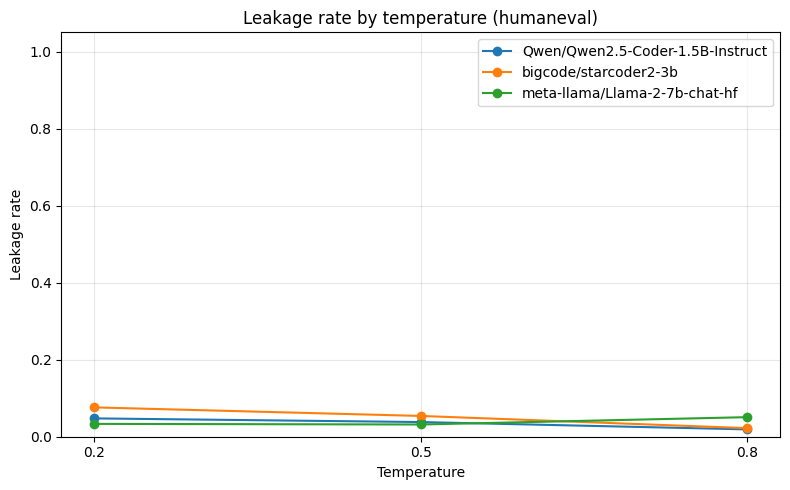

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/leakage_rate_by_temp_humaneval.png


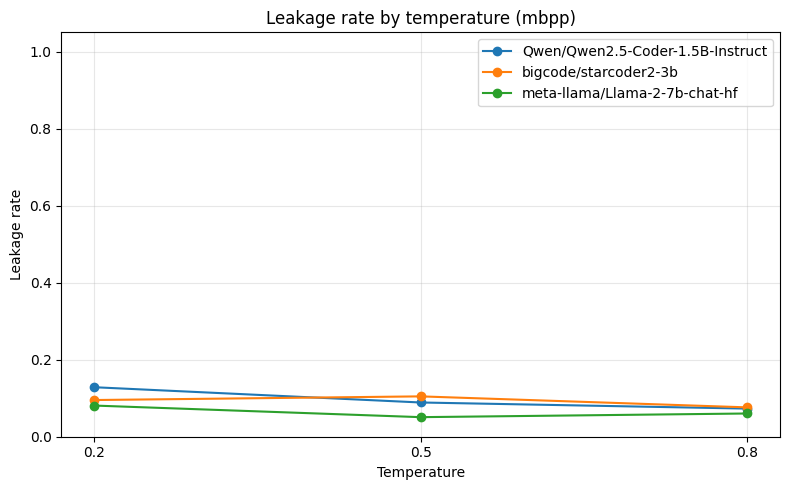

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/leakage_rate_by_temp_mbpp.png


In [39]:
plot_metric_vs_temperature(
    summary,
    metric="leakage_rate",
    title_prefix="Leakage rate by temperature",
    ylabel="Leakage rate",
    save_name="leakage_rate_by_temp",
)

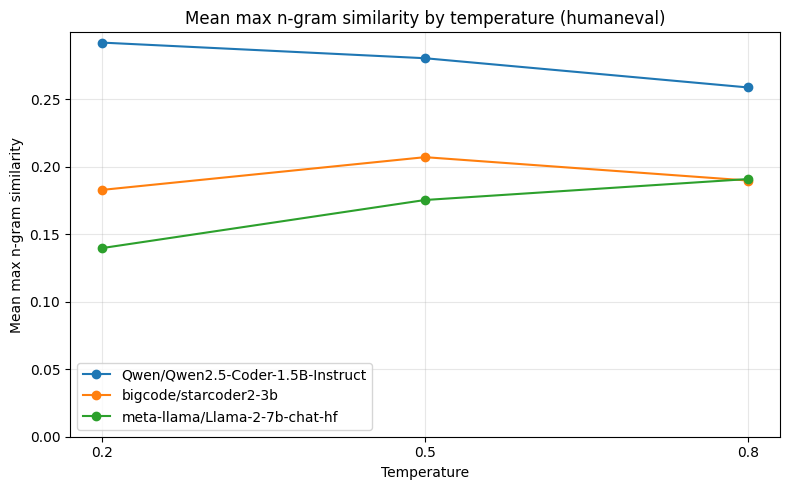

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/mean_max_ngram_by_temp_humaneval.png


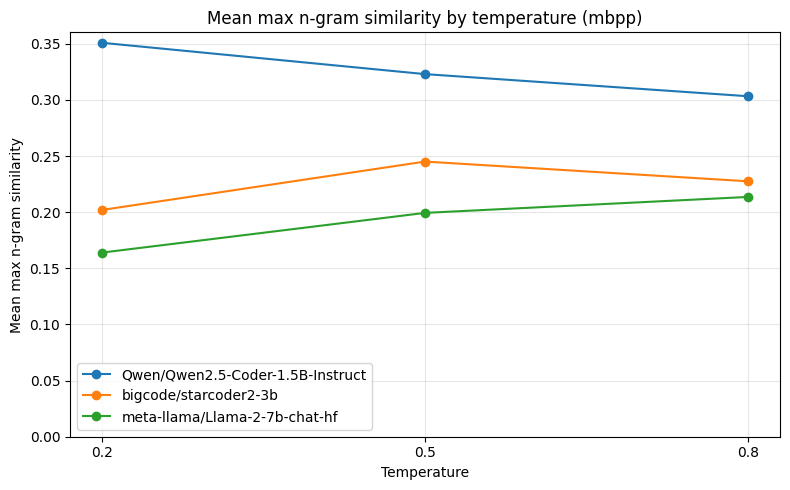

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/mean_max_ngram_by_temp_mbpp.png


In [40]:
plot_metric_vs_temperature(
    summary,
    metric="mean_max_ngram",
    title_prefix="Mean max n-gram similarity by temperature",
    ylabel="Mean max n-gram similarity",
    save_name="mean_max_ngram_by_temp",
)

In [41]:
detail_paths = []
for p in RESULTS_DIR.rglob("*.csv"):
    if p.name == "summary.csv":
        continue
    # your naming pattern: <stem>_vs_<ref>.csv
    if "_vs_" in p.name:
        detail_paths.append(p)

detail_paths = sorted(detail_paths)
print("Found detailed CSVs:", len(detail_paths))
for p in detail_paths[:10]:
    print(" -", p)

dfs = []
for p in detail_paths:
    try:
        d = pd.read_csv(p)
        d["source_file"] = str(p)
        # normalize types if present
        if "temperature" in d.columns:
            d["temperature"] = pd.to_numeric(d["temperature"], errors="coerce")
        if "max_ngram_score" in d.columns:
            d["max_ngram_score"] = pd.to_numeric(d["max_ngram_score"], errors="coerce")
        dfs.append(d)
    except Exception as e:
        print("FAILED reading:", p, "->", e)

details = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
print("Details rows:", len(details), "cols:", list(details.columns))
display(details.head(10))

Found detailed CSVs: 18
 - /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/llama/LLaMA2-7B-Chat-Temperature-0.2_vs_humaneval.csv
 - /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/llama/LLaMA2-7B-Chat-Temperature-0.2_vs_mbpp.csv
 - /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/llama/LLaMA2-7B-Chat-Temperature-0.5_vs_humaneval.csv
 - /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/llama/LLaMA2-7B-Chat-Temperature-0.5_vs_mbpp.csv
 - /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/llama/LLaMA2-7B-Chat-Temperature-0.8_vs_humaneval.csv
 - /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/llama/LLaMA2-7B-Chat-Temperature-0.8_vs_mbpp.csv
 - /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/qwen/Qwen2.5-Coder-1.5B-Instruct-Temperature-0.2_vs_humaneval.csv
 - /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/qwen/Qwen

,model,temperature,reference_dataset,private_id,sample_id,n_generated_asserts,max_ngram_score,max_ngram_ref_id,leaked,leak_reason,top1_ref_id,top1_ngram,top2_ref_id,top2_ngram,top3_ref_id,top3_ngram,source_file
0,meta-llama/Llama-2-7b-chat-hf,0.2,humaneval,private_1,0,2,0.256098,humaneval_125,False,below_threshold,humaneval_125,0.256098,humaneval_117,0.250000,humaneval_74,0.222222,/Users/aruzhan/Desktop/Univaq/SE_ML/Data Leaka...
1,meta-llama/Llama-2-7b-chat-hf,0.2,humaneval,private_1,1,0,0.000000,NaN,False,no_asserts,NaN,NaN,NaN,NaN,NaN,NaN,/Users/aruzhan/Desktop/Univaq/SE_ML/Data Leaka...
2,meta-llama/Llama-2-7b-chat-hf,0.2,humaneval,private_2,0,5,0.558442,humaneval_145,True,ngram>=0.5,humaneval_145,0.558442,humaneval_135,0.521127,humaneval_69,0.513514,/Users/aruzhan/Desktop/Univaq/SE_ML/Data Leaka...
3,meta-llama/Llama-2-7b-chat-hf,0.2,humaneval,private_2,1,0,0.000000,NaN,False,no_asserts,NaN,NaN,NaN,NaN,NaN,NaN,/Users/aruzhan/Desktop/Univaq/SE_ML/Data Leaka...
4,meta-llama/Llama-2-7b-chat-hf,0.2,humaneval,private_3,0,1,0.212500,humaneval_86,False,below_threshold,humaneval_86,0.212500,humaneval_91,0.180556,humaneval_125,0.172840,/Users/aruzhan/Desktop/Univaq/SE_ML/Data Leaka...
5,meta-llama/Llama-2-7b-chat-hf,0.2,humaneval,private_3,1,0,0.000000,NaN,False,no_asserts,NaN,NaN,NaN,NaN,NaN,NaN,/Users/aruzhan/Desktop/Univaq/SE_ML/Data Leaka...
6,meta-llama/Llama-2-7b-chat-hf,0.2,humaneval,private_4,0,0,0.000000,NaN,False,no_asserts,NaN,NaN,NaN,NaN,NaN,NaN,/Users/aruzhan/Desktop/Univaq/SE_ML/Data Leaka...
7,meta-llama/Llama-2-7b-chat-hf,0.2,humaneval,private_4,1,0,0.000000,NaN,False,no_asserts,NaN,NaN,NaN,NaN,NaN,NaN,/Users/aruzhan/Desktop/Univaq/SE_ML/Data Leaka...
8,meta-llama/Llama-2-7b-chat-hf,0.2,humaneval,private_5,0,0,0.000000,NaN,False,no_asserts,NaN,NaN,NaN,NaN,NaN,NaN,/Users/aruzhan/Desktop/Univaq/SE_ML/Data Leaka...
9,meta-llama/Llama-2-7b-chat-hf,0.2,humaneval,private_5,1,0,0.000000,NaN,False,no_asserts,NaN,NaN,NaN,NaN,NaN,NaN,/Users/aruzhan/Desktop/Univaq/SE_ML/Data Leaka...


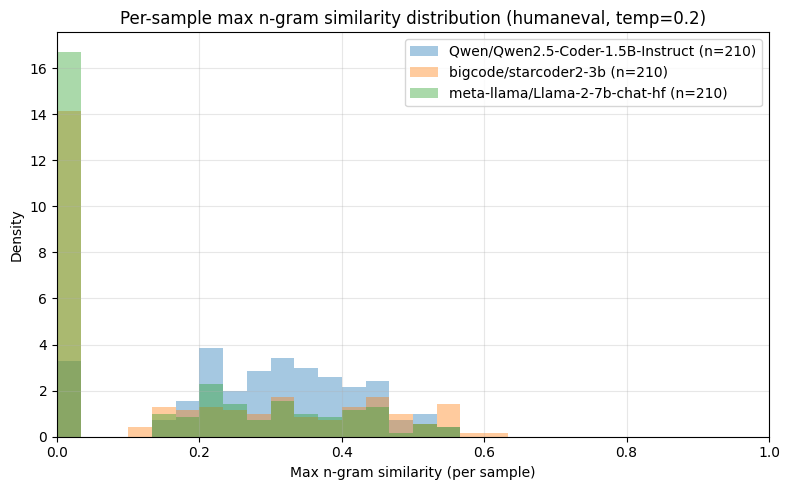

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/ngram_hist_humaneval_temp_0.2.png


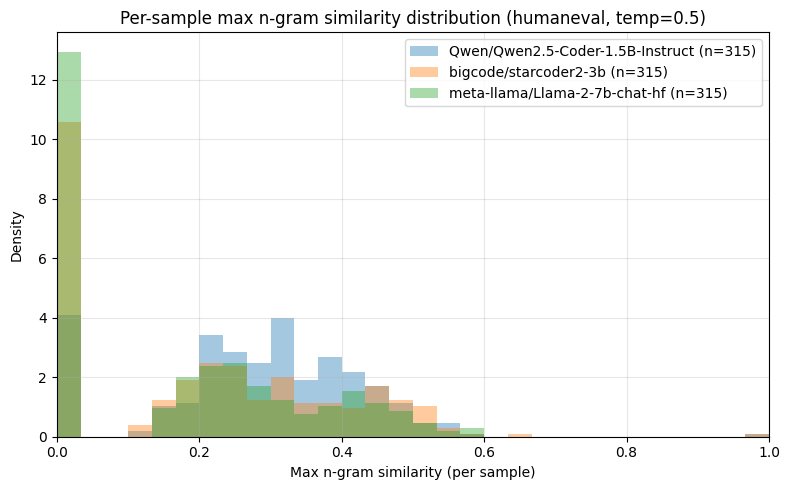

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/ngram_hist_humaneval_temp_0.5.png


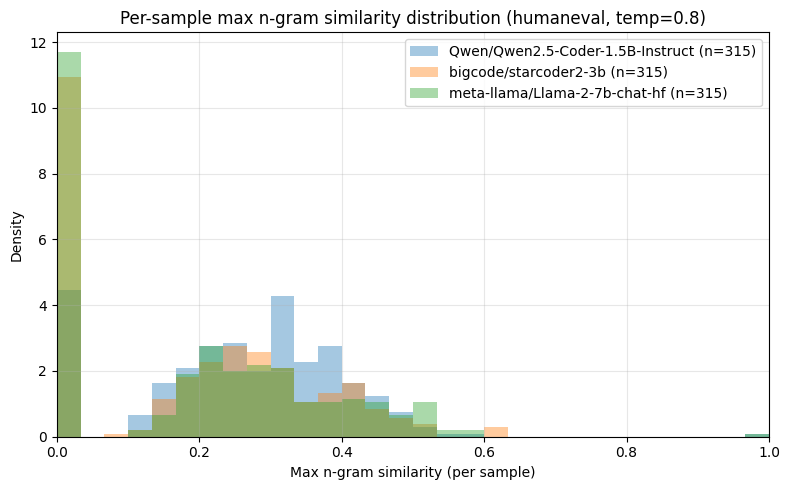

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/ngram_hist_humaneval_temp_0.8.png


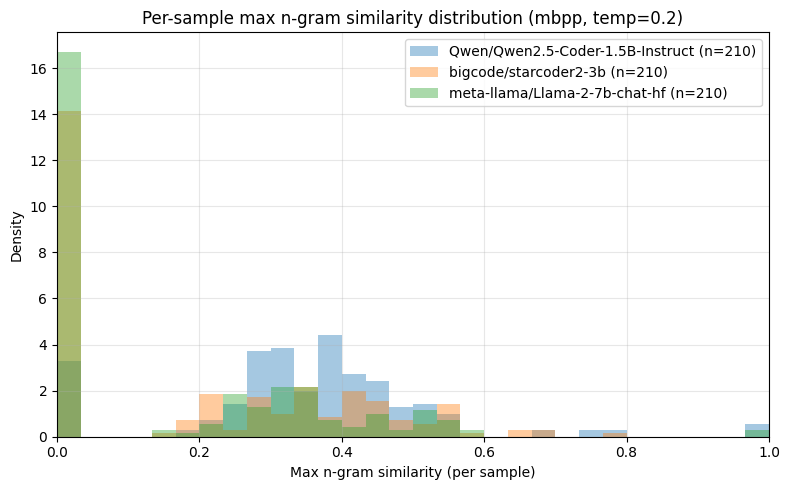

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/ngram_hist_mbpp_temp_0.2.png


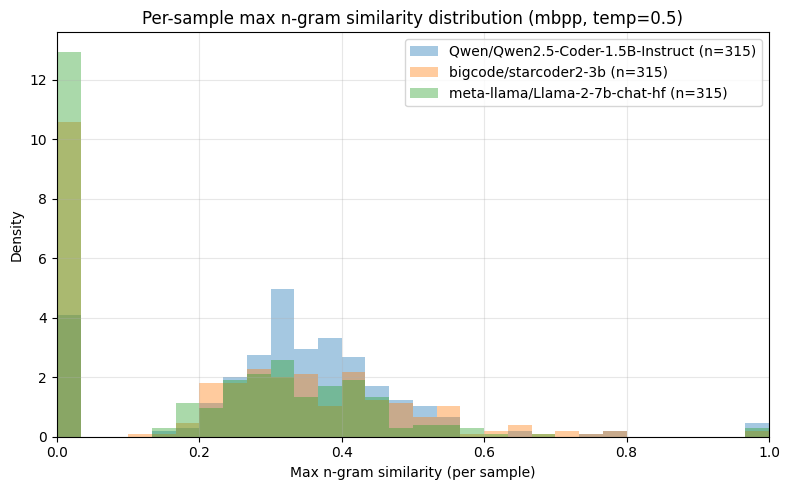

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/ngram_hist_mbpp_temp_0.5.png


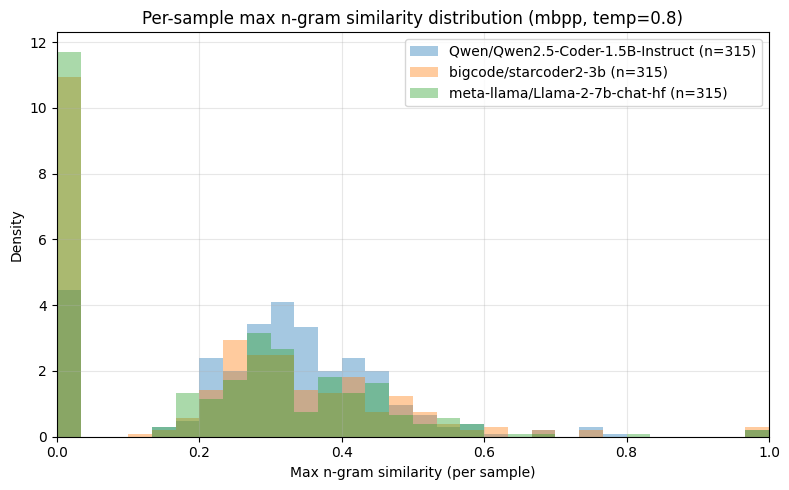

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/ngram_hist_mbpp_temp_0.8.png


In [42]:
required_cols = {"model", "reference_dataset", "temperature", "max_ngram_score"}
missing = required_cols - set(details.columns)
if missing:
    raise ValueError(f"Missing required columns in details: {missing}")

datasets = sorted(details["reference_dataset"].dropna().unique())
temps = sorted(details["temperature"].dropna().unique())
models = sorted(details["model"].dropna().unique())

bins = np.linspace(0, 1.0, 31)  # 0..1, 30 bins

for ref in datasets:
    for t in temps:
        sub = details[(details["reference_dataset"] == ref) & (details["temperature"] == t)].copy()
        if sub.empty:
            continue

        plt.figure(figsize=(8, 5))
        for m in models:
            s = sub[sub["model"] == m]["max_ngram_score"].dropna().values
            if len(s) == 0:
                continue
            plt.hist(s, bins=bins, alpha=0.4, density=True, label=f"{m} (n={len(s)})")

        plt.title(f"Per-sample max n-gram similarity distribution ({ref}, temp={t})")
        plt.xlabel("Max n-gram similarity (per sample)")
        plt.ylabel("Density")
        plt.xlim(0, 1.0)
        plt.grid(True, alpha=0.3)
        plt.legend(loc="best")

        out = FIG_DIR / f"ngram_hist_{ref}_temp_{t}.png"
        plt.tight_layout()
        plt.savefig(out, dpi=200)
        plt.show()

        print("Saved:", out)

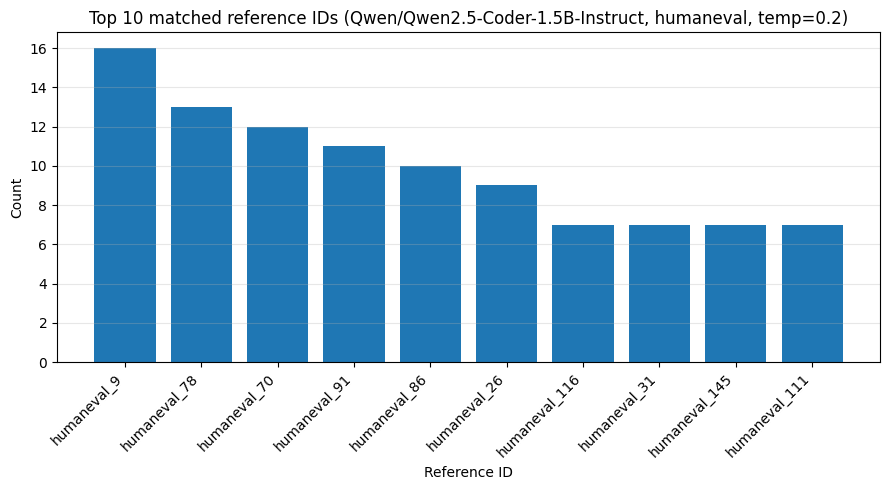

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/top_ref_ids_Qwen_Qwen2.5-Coder-1.5B-Instruct_humaneval_temp_0.2.png


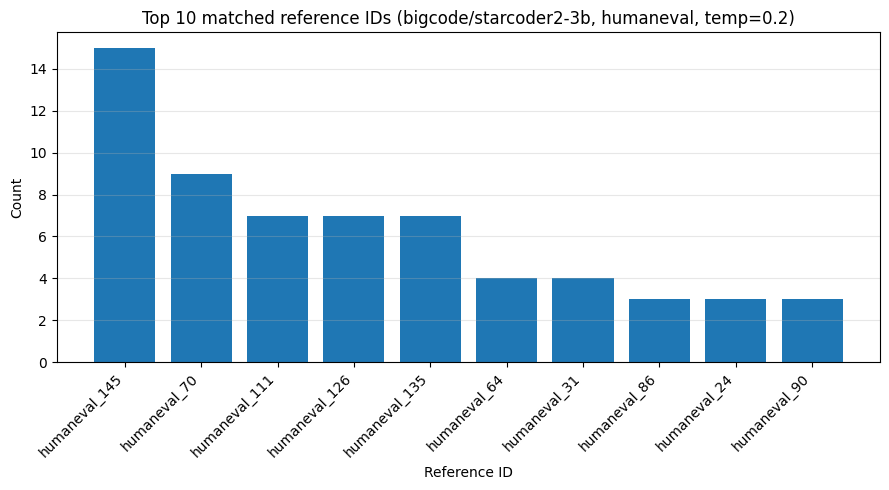

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/top_ref_ids_bigcode_starcoder2-3b_humaneval_temp_0.2.png


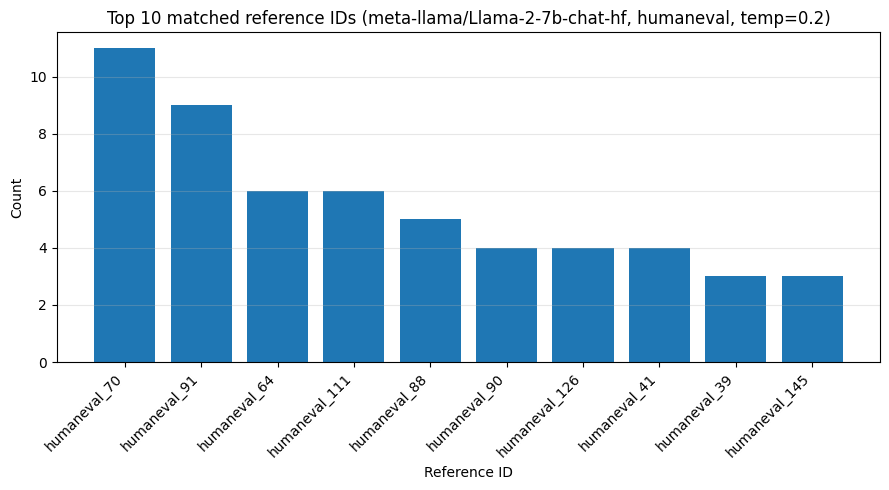

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/top_ref_ids_meta-llama_Llama-2-7b-chat-hf_humaneval_temp_0.2.png


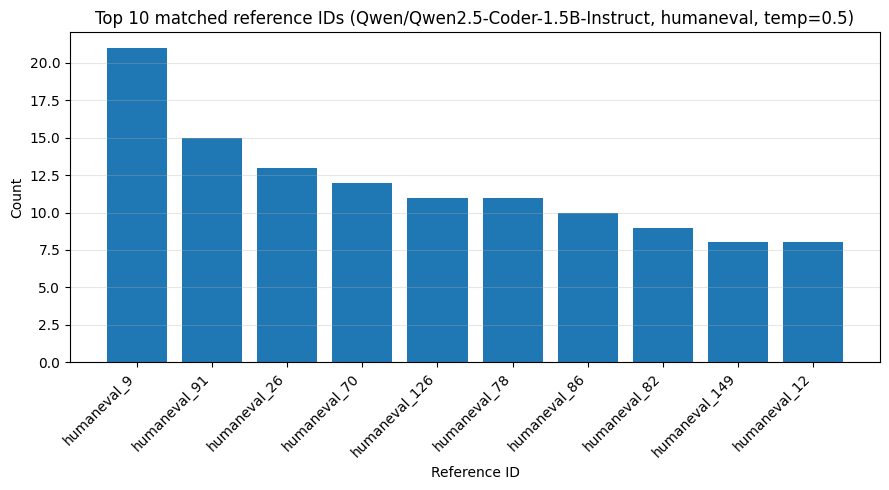

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/top_ref_ids_Qwen_Qwen2.5-Coder-1.5B-Instruct_humaneval_temp_0.5.png


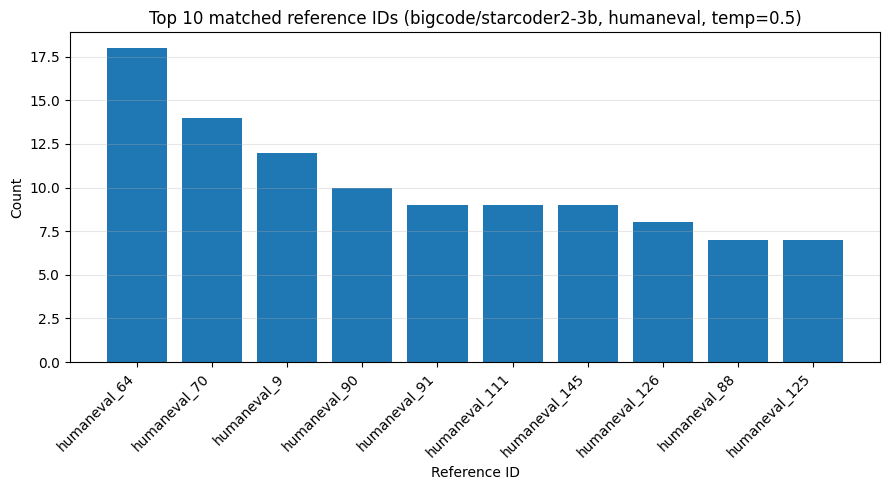

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/top_ref_ids_bigcode_starcoder2-3b_humaneval_temp_0.5.png


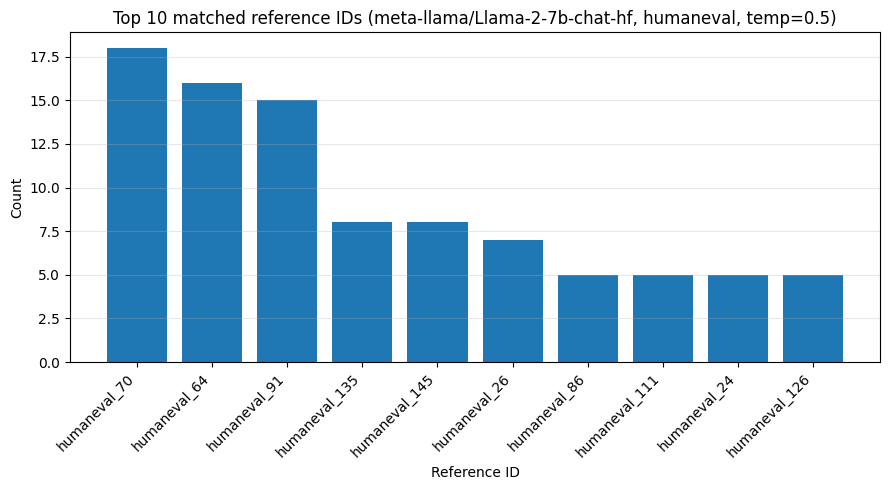

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/top_ref_ids_meta-llama_Llama-2-7b-chat-hf_humaneval_temp_0.5.png


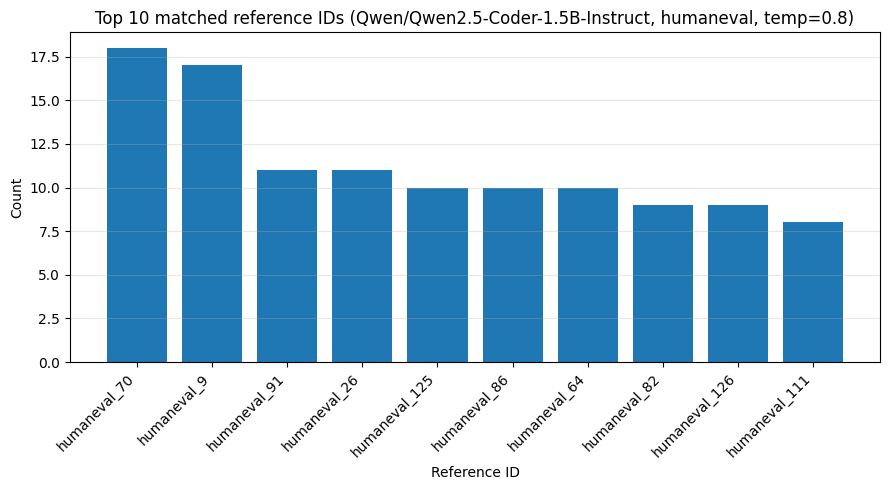

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/top_ref_ids_Qwen_Qwen2.5-Coder-1.5B-Instruct_humaneval_temp_0.8.png


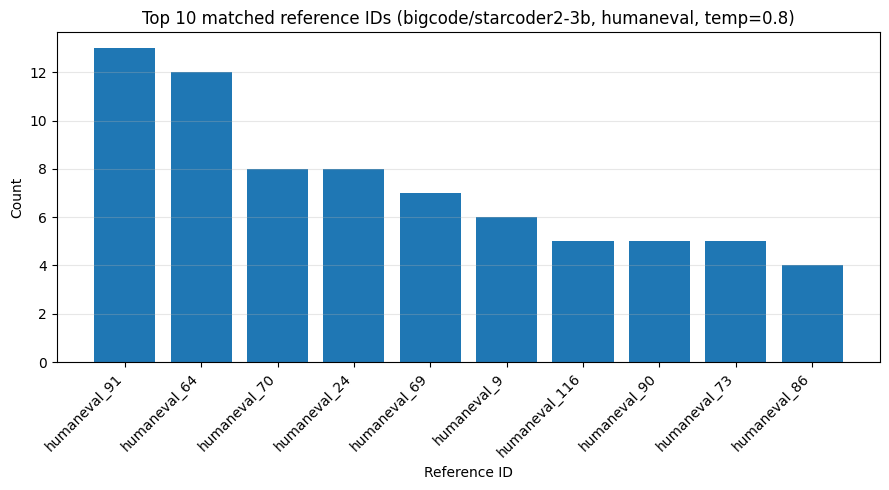

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/top_ref_ids_bigcode_starcoder2-3b_humaneval_temp_0.8.png


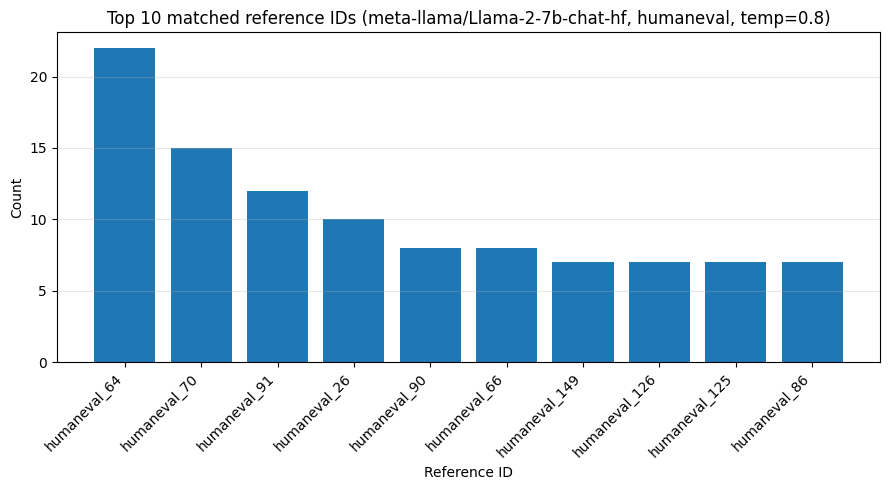

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/top_ref_ids_meta-llama_Llama-2-7b-chat-hf_humaneval_temp_0.8.png


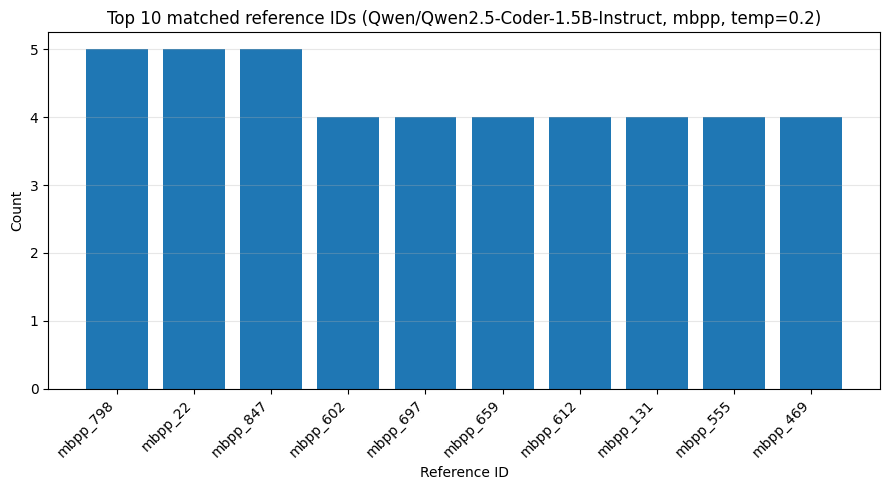

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/top_ref_ids_Qwen_Qwen2.5-Coder-1.5B-Instruct_mbpp_temp_0.2.png


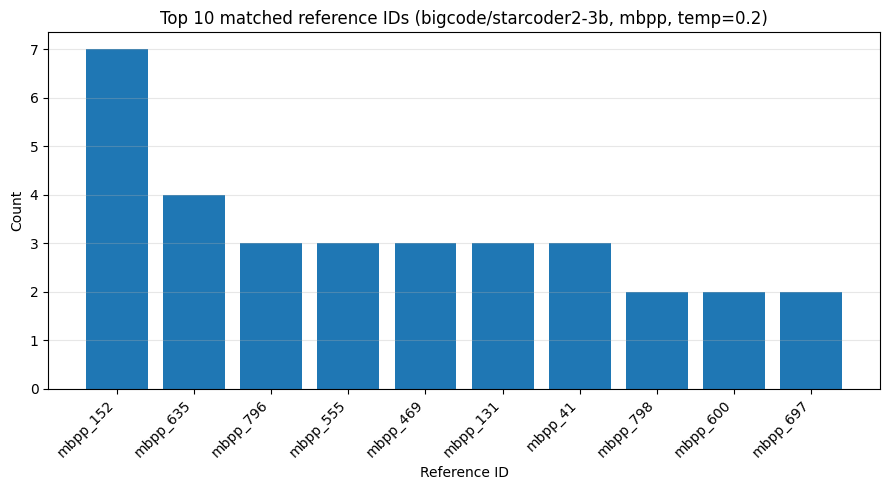

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/top_ref_ids_bigcode_starcoder2-3b_mbpp_temp_0.2.png


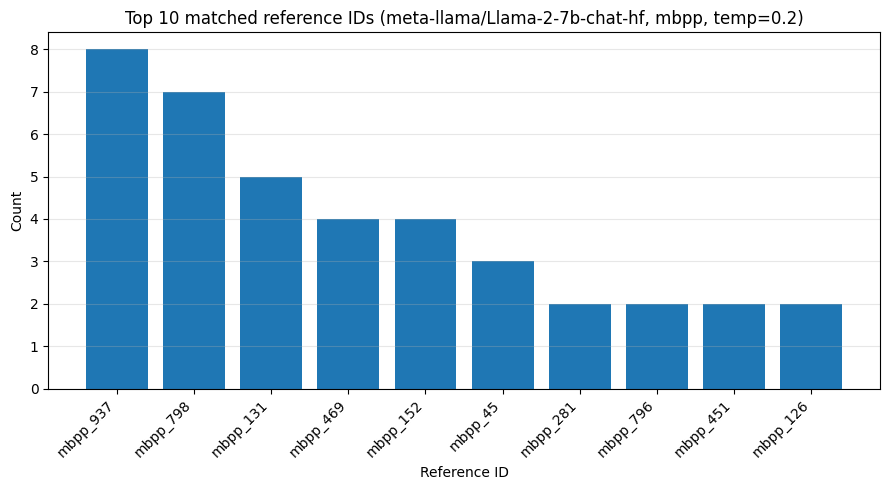

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/top_ref_ids_meta-llama_Llama-2-7b-chat-hf_mbpp_temp_0.2.png


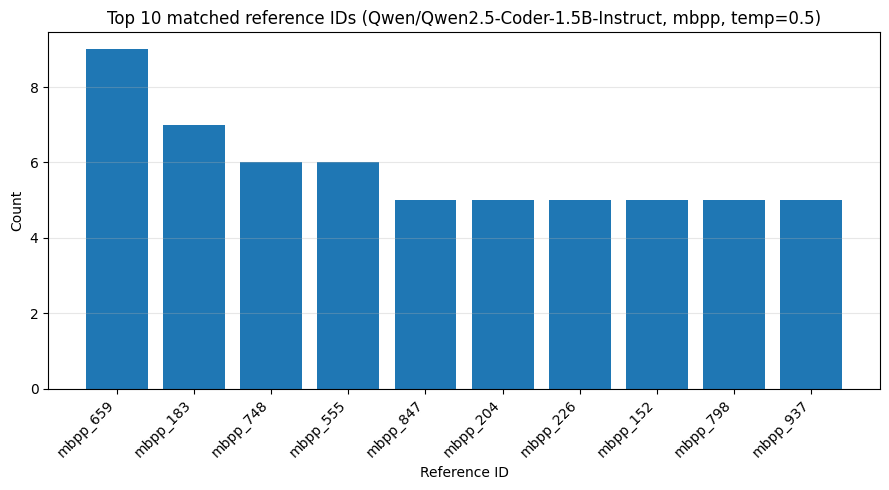

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/top_ref_ids_Qwen_Qwen2.5-Coder-1.5B-Instruct_mbpp_temp_0.5.png


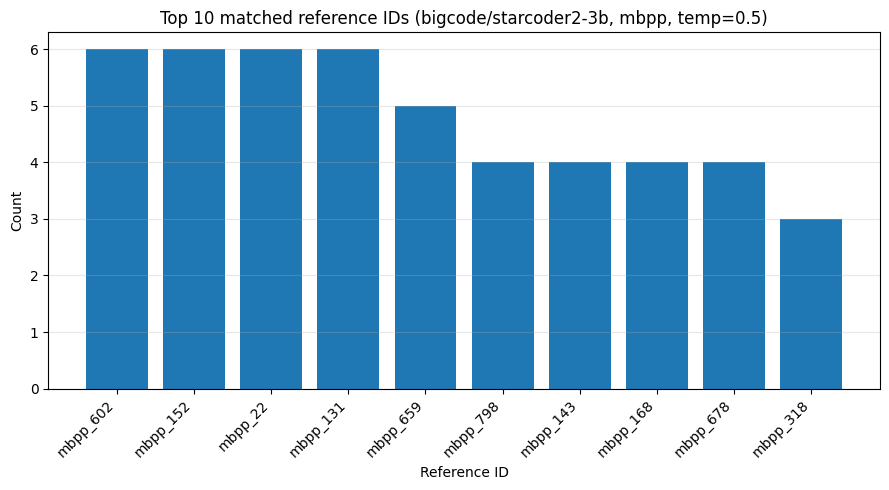

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/top_ref_ids_bigcode_starcoder2-3b_mbpp_temp_0.5.png


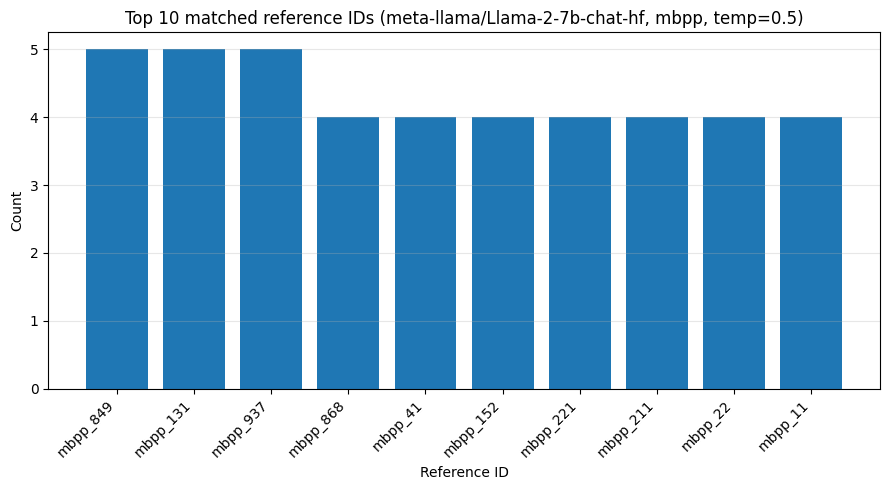

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/top_ref_ids_meta-llama_Llama-2-7b-chat-hf_mbpp_temp_0.5.png


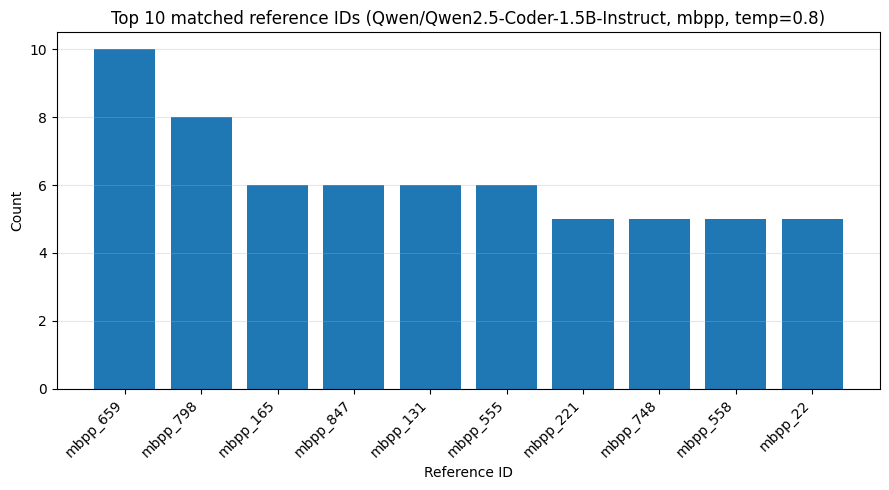

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/top_ref_ids_Qwen_Qwen2.5-Coder-1.5B-Instruct_mbpp_temp_0.8.png


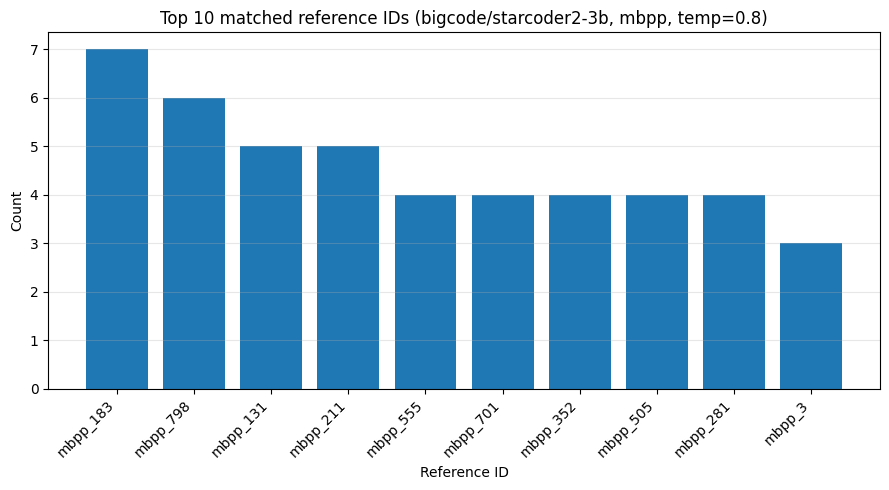

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/top_ref_ids_bigcode_starcoder2-3b_mbpp_temp_0.8.png


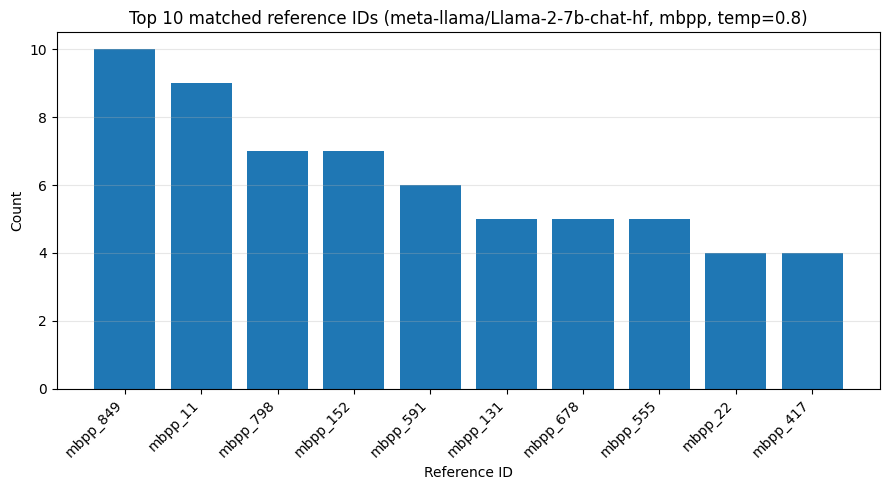

Saved: /Users/aruzhan/Desktop/Univaq/SE_ML/Data Leakage for Test Case/results/figures/top_ref_ids_meta-llama_Llama-2-7b-chat-hf_mbpp_temp_0.8.png


In [44]:
if "max_ngram_ref_id" not in details.columns:
    print("max_ngram_ref_id not found in detailed CSVs; skipping.")
else:
    # pick each (dataset, temp, model) and make a top-10 bar plot
    datasets = sorted(details["reference_dataset"].dropna().unique())
    temps = sorted(details["temperature"].dropna().unique())
    models = sorted(details["model"].dropna().unique())

    TOP_N = 10

    for ref in datasets:
        for t in temps:
            for m in models:
                sub = details[
                    (details["reference_dataset"] == ref)
                    & (details["temperature"] == t)
                    & (details["model"] == m)
                ].copy()

                if sub.empty:
                    continue

                counts = (
                    sub["max_ngram_ref_id"]
                    .dropna()
                    .astype(str)
                    .value_counts()
                    .head(TOP_N)
                )
                if counts.empty:
                    continue

                plt.figure(figsize=(9, 5))
                plt.bar(counts.index.astype(str), counts.values)
                plt.title(f"Top {TOP_N} matched reference IDs ({m}, {ref}, temp={t})")
                plt.xlabel("Reference ID")
                plt.ylabel("Count")
                plt.xticks(rotation=45, ha="right")
                plt.grid(True, axis="y", alpha=0.3)

                out = FIG_DIR / f"top_ref_ids_{m.replace('/','_')}_{ref}_temp_{t}.png"
                plt.tight_layout()
                plt.savefig(out, dpi=200)
                plt.show()

                print("Saved:", out)

In [45]:
report = summary.copy()
report["leakage_rate"] = report["leakage_rate"].round(3)
report["mean_max_ngram"] = report["mean_max_ngram"].round(3)

display(report.sort_values(["reference_dataset", "model", "temperature"]))

,model,temperature,reference_dataset,total_samples,leaked_samples,leakage_rate,mean_max_ngram
0,Qwen/Qwen2.5-Coder-1.5B-Instruct,0.2,humaneval,210,10,0.048,0.292
1,Qwen/Qwen2.5-Coder-1.5B-Instruct,0.5,humaneval,315,12,0.038,0.280
2,Qwen/Qwen2.5-Coder-1.5B-Instruct,0.8,humaneval,315,6,0.019,0.259
3,bigcode/starcoder2-3b,0.2,humaneval,210,16,0.076,0.183
4,bigcode/starcoder2-3b,0.5,humaneval,315,17,0.054,0.207
5,bigcode/starcoder2-3b,0.8,humaneval,315,7,0.022,0.190
6,meta-llama/Llama-2-7b-chat-hf,0.2,humaneval,210,7,0.033,0.140
7,meta-llama/Llama-2-7b-chat-hf,0.5,humaneval,315,10,0.032,0.175
8,meta-llama/Llama-2-7b-chat-hf,0.8,humaneval,315,16,0.051,0.191
9,Qwen/Qwen2.5-Coder-1.5B-Instruct,0.2,mbpp,210,27,0.129,0.351
